# Advanced line finding using computer vision
In this project, the goal is to write a software pipeline to identify the lane boundaries in a video from a front-facing camera on a car. To that end, camera calibration images, test road images, and project videos are available in the project repository or in the repository folder included with the workspace. This project involves the following tasks

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


All these elements are gathered in a final pipeline designed to find lane boundaries in a video. The pipeline adds some connection between consecutive frames that are processed.

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
import os
from collections import deque
%matplotlib inline

In [3]:
path_test_images = 'test_images' # Folder containing images for test images
test_images = glob.glob(path_test_images+'/*.jpg') # Test images
path_image_cal = 'camera_cal' # Folder containing images for camera calibration
path_out = 'output_images'
straightline_images = glob.glob(path_test_images+'/straight*.jpg') # Test images with straight lines

# 1 - Camera calibration 
The purpose of this part is to use OpenCV to compute the camera matrix and the distortion coefficients of the camera embedded on the car. To do so, we use the OpenCV function findChessboardCorners() to automatically find  in an image of a chessboard pattern and then use the OpenCV functions cv2.calibrateCamera() and cv2.undistort() to compute the calibration and undistortion.

In [4]:
images = glob.glob(path_image_cal + '/*.jpg') # Make a list images used for calibration
nx, ny = 9, 6 # Expected chessboard features (row x columns)

### Collect data

In [5]:
# Expected location of the corner
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname) # Load the image in BGR 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

### Computation of camera matrix and distorsion coefficients

In [6]:
img_size = img.shape[:2]
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

In [7]:
! ls output_images

calibration10result.jpg  calibration4result.jpg       test1binary.jpg
calibration11result.jpg  calibration5result.jpg       test1final.jpg
calibration12result.jpg  calibration6result.jpg       test2binary.jpg
calibration13result.jpg  calibration7result.jpg       test2final.jpg
calibration14result.jpg  calibration8result.jpg       test3binary.jpg
calibration15result.jpg  calibration9result.jpg       test3final.jpg
calibration16result.jpg  find_lane_without_prior.jpg  test4binary.jpg
calibration17result.jpg  find_lane_with_prior.jpg     test4final.jpg
calibration18result.jpg  save_output_here.txt	      test4undistortion.jpg
calibration19result.jpg  straight_lines1binary.jpg    test5binary.jpg
calibration1result.jpg	 straight_lines1bird.jpg      test5final.jpg
calibration20result.jpg  straight_lines1final.jpg     test6binary.jpg
calibration2result.jpg	 straight_lines2binary.jpg    test6final.jpg
calibration3result.jpg	 straight_lines2final.jpg


In [8]:
fname

'camera_cal/calibration18.jpg'

### Test image calibration

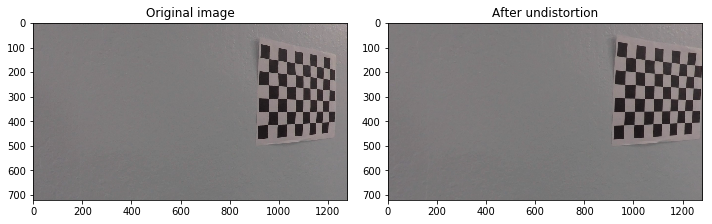

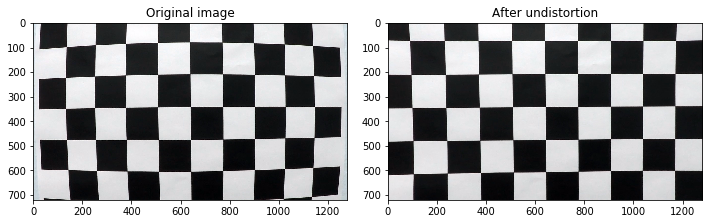

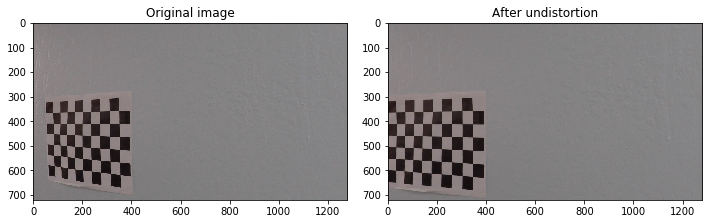

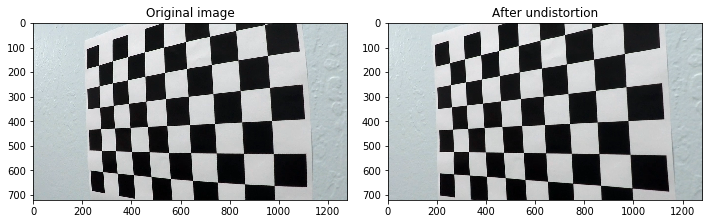

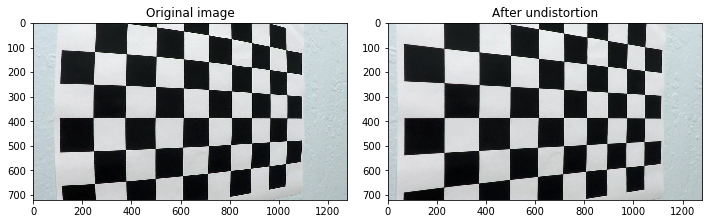

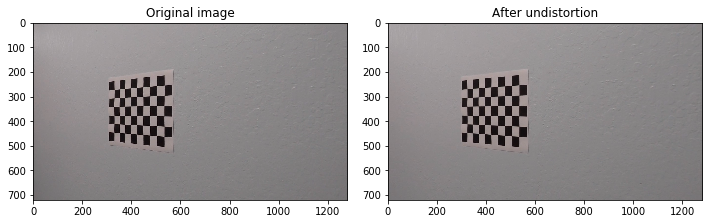

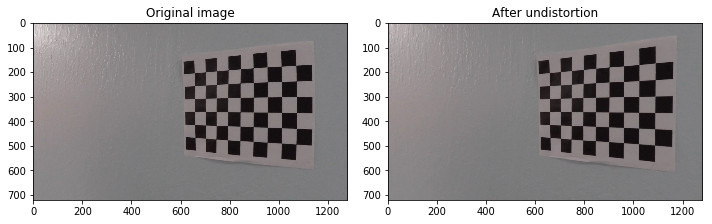

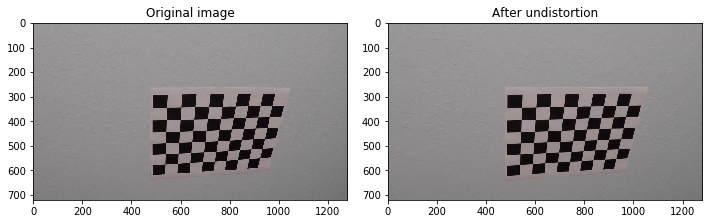

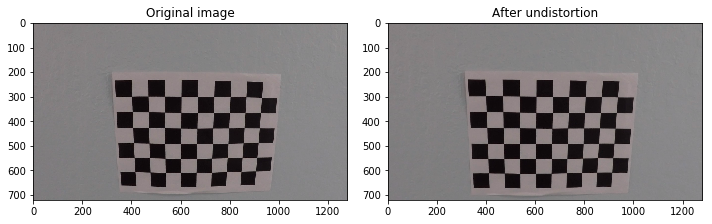

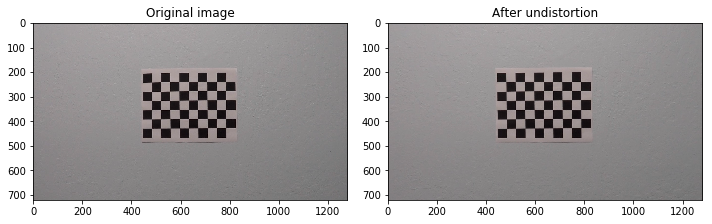

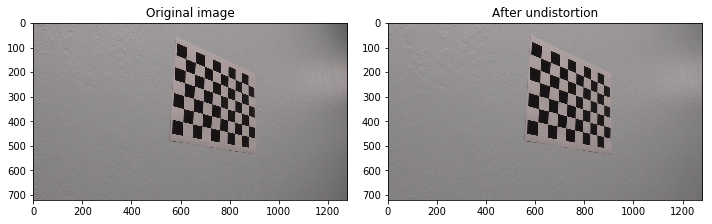

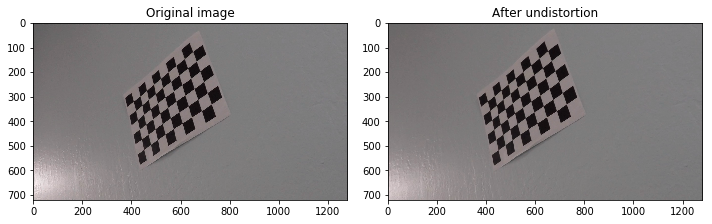

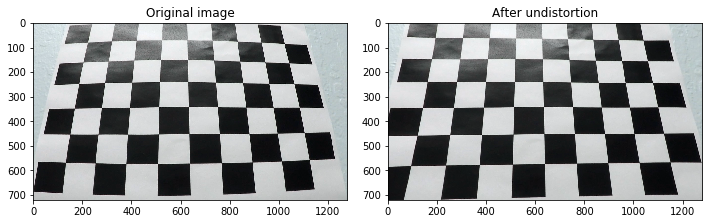

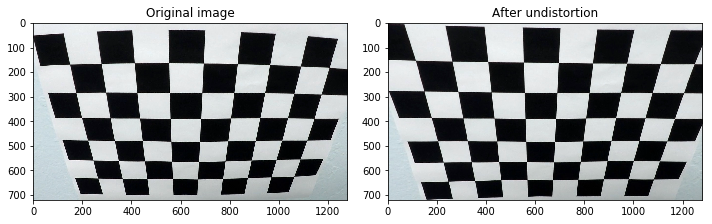

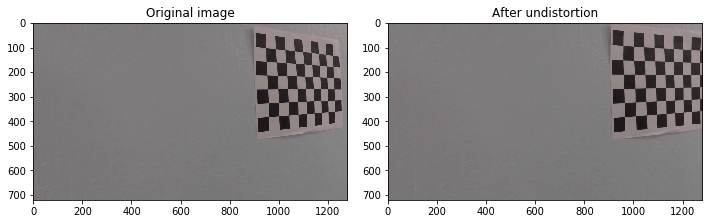

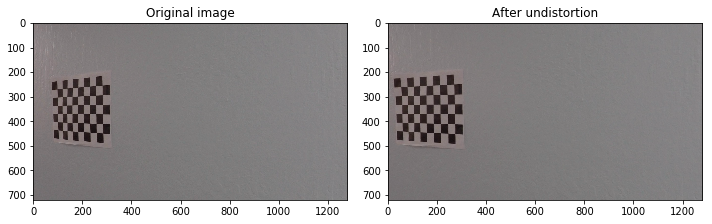

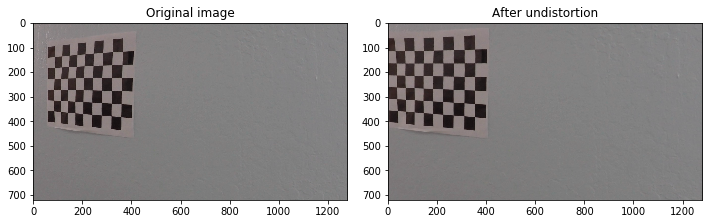

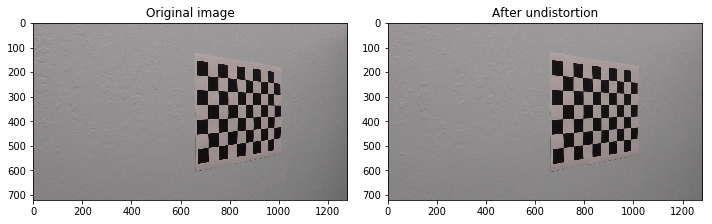

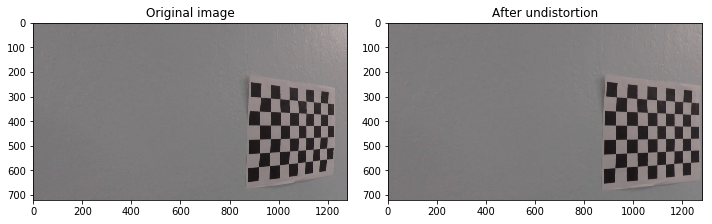

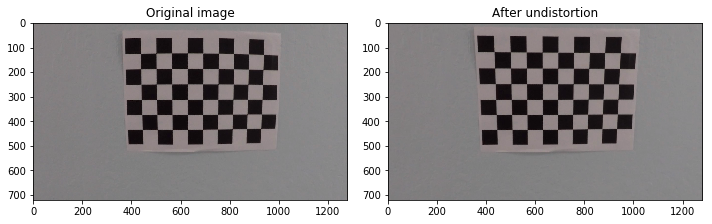

In [9]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname) # Load the image in BGR 
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,20))
    # Draw original image
    ax[0].imshow(img)
    ax[0].set_title('Original image')
    # Draw image after undistortion
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    ax[1].imshow(dst)
    ax[1].set_title('After undistortion')
    f.tight_layout()
    plt.show()
    name = fname.replace(path_image_cal, path_out).replace('.jpg','result.jpg')
    f.savefig(name)

### Save camera matrix and distortion coefficients / undistortion method definition

In [10]:
# Save the camera calibration result for later use 
name_calibration = 'calibration.p' 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( name_calibration, "wb" ) )

In [11]:
def undistortion(img):
    '''
    This functions return the image after undistortion. Assumes that
    - mtx, camera matrix, exists in the workspace 
    - dist, distortion coefficients vector, exists in the workspace
    '''
    return cv2.undistort(img, mtx, dist, None, mtx)

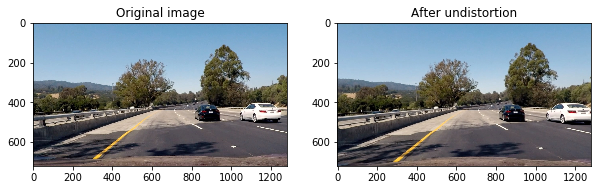

In [12]:
test_image = test_images[0]
img = (cv2.imread(test_image))
# Undistorsion
img_un = undistortion(img)
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,20))
# Draw original image
ax[0].imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
ax[0].set_title('Original image')
# Draw image after undistortion
ax[1].imshow(cv2.cvtColor(img_un,cv2.COLOR_BGR2RGB))
ax[1].set_title('After undistortion')
plt.show()
name = test_image.replace(path_test_images, path_out).replace('.jpg','undistortion.jpg')
f.savefig(name)

# 2- Binary image pipeline

The purpose of this part is to establish an intermediary pipeline that will take as input an image with three chanels and will give as output a binary image where one's would indicate lane marking on the road. To do so, we will use gradient thresholding as well as channels provided by the HLS space (hue, lightness, and saturation).

### Useful functions

In [13]:
def abs_threshold(chanel, orient='x', abs_thresh=(0, 255)):
    '''
    This functions applies a sobel operator on a single indicated axis and applies a thresholding 
    on the result to provide a binary output
    '''
    # Calculate directional gradient
    if orient == 'x' :
        sobel = cv2.Sobel(chanel, cv2.CV_64F, 1, 0)
    elif orient == 'y' :
        sobel = cv2.Sobel(chanel, cv2.CV_64F, 0, 1)
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    # Apply threshold
    mask = np.zeros_like(chanel)
    mask[(scaled_sobel > abs_thresh[0]) & (scaled_sobel < abs_thresh[1])] = 1
    return mask


In [14]:
def mag_threshold(chanel, sobel_kernel = 3, mag_thresh=(0, 255)):
    '''
    This functions applies a sobel operator on both axes and applies a thresholding 
    on the resulting gradient magnitude to provide a binary output
    '''
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(chanel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(chanel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    return binary_output

In [15]:
def dir_threshold(chanel, sobel_kernel = 3, dir_thresh=(0, np.pi/2)):
    '''
    This functions applies a sobel operator on both axes and applies a thresholding 
    on the resulting gradient direction to provide a binary output
    '''
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(chanel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(chanel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1

    # Return the binary image
    return binary_output

### Pipeline for binarising an image

In [16]:
def binary_pipeline(image, thresholds):
    '''
    This functions takes a BGR image and several thresholds (on the the magnitude and direction of the bidirectionnal gradient
    , on the magnitude of unidirectionnal gradient computed on the lightness channel as well as on the strength of the saturation channel). It returns a binary
    image that combines all the different thresholdings
    '''
    
    img = np.copy(image)
    # Convert to HLS color space and separate the channels
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
  
    # 1- Color thresholding on saturation channel
    saturation_binary = np.zeros_like(s_channel)
    saturation_binary[(s_channel >= thresholds['saturation'][0]) & (s_channel <= thresholds['saturation'][1])] = 1
    
    # 2- Gradient thresholding on lightness channel
    # Different thresholding
    abs_binary_x = abs_threshold(l_channel, orient='x', abs_thresh=thresholds['absx'])
    abs_binary_y = abs_threshold(l_channel, orient='y', abs_thresh=thresholds['absy'])
    mag_binary = mag_threshold(l_channel, mag_thresh=thresholds['mag'])
    dir_binary = dir_threshold(l_channel, dir_thresh=thresholds['dir'])
    # Combining
    gradient_binary = np.zeros_like(dir_binary)
    gradient_binary[((abs_binary_x == 1) & (abs_binary_y == 1)) |((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # 3- Fusion
    binary = np.zeros_like(dir_binary)
    binary[(gradient_binary == 1) | (saturation_binary == 1)] = 1
    
    # (VISUALIZATION: for distinguishing the different contributions)
    colored_binary = np.zeros_like(img)
    colored_binary[:,:,1] = saturation_binary*255
    colored_binary[:,:,2] = gradient_binary*255

    return binary, colored_binary

### Testing the pipeline
Here we test the pipeline on the different test images. On the left, the original image, in the middle the binary output and the right the contributions of the gradient tresholding on the lightness channel (blue) and the thresholding on the saturation channel (green).

In [17]:
thresholds = {'mag':[50,150], 
              'dir':[np.pi/6, np.pi/2],
              'absx':[50,150],
              'absy':[50,150],
              'saturation':[170, 255]
             }

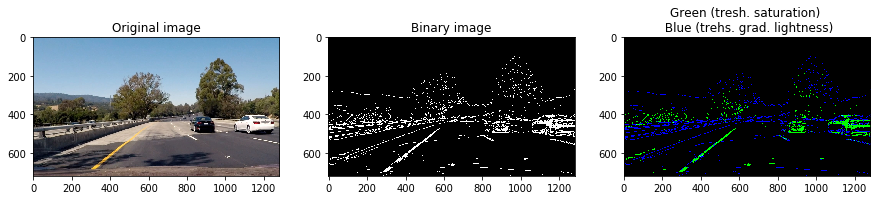

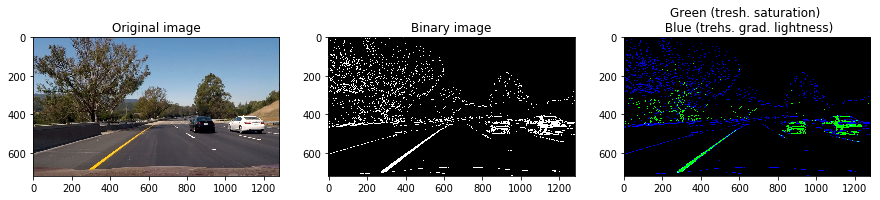

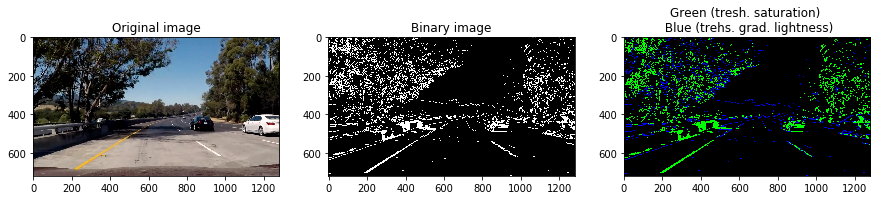

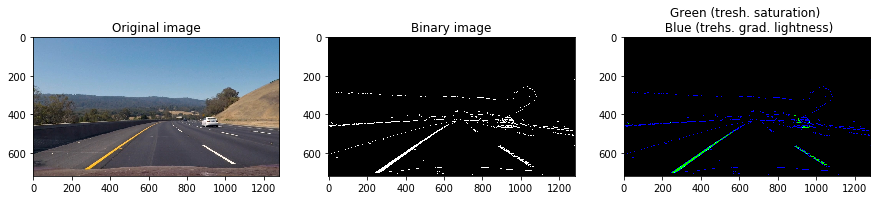

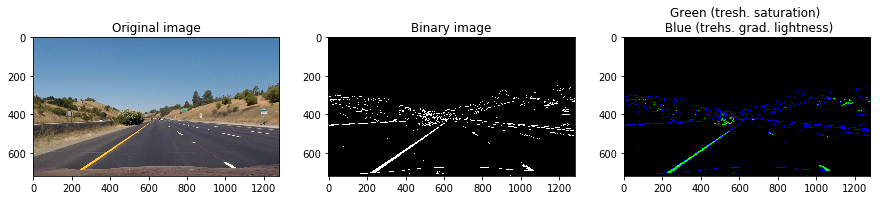

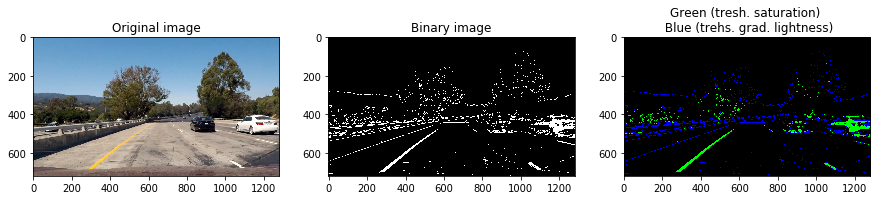

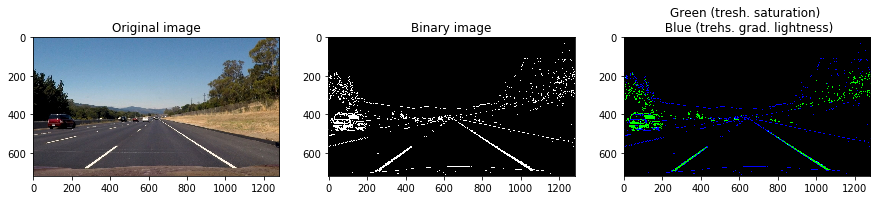

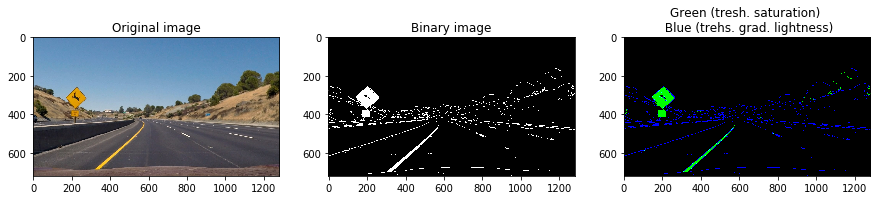

In [18]:
for fname in test_images:
    img = cv2.imread(fname)
    # Undistorsion
    img_un = undistortion(img)
    # Binarising
    binary, colored_binary = binary_pipeline(img_un,thresholds)
    # Plot the result
    f, ax = plt.subplots(1, 3, figsize=(15,30))
    # Draw original image
    ax[0].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB) )
    ax[0].set_title('Original image')
    # Draw binary
    ax[1].imshow(binary,cmap='gray')
    ax[1].set_title('Binary image')
    # Display the contributions
    ax[2].imshow(colored_binary)
    ax[2].set_title('Green (tresh. saturation) \n Blue (trehs. grad. lightness)')
    name = fname.replace(path_test_images, path_out).replace('.jpg','binary.jpg')
    f.savefig(name)
    

# 3- Perspective transform

A perspective transform maps the points in a given image to different, desired, image points with a new perspective. The perspective transform we are interested in here is a bird’s-eye view transform that let’s us view a lane from above; this will be useful for calculating the lane curvature later on. Aside from creating a bird’s eye view representation of an image, a perspective transform can also be used for all kinds of different view points.

To compute the perspective transform, we need a set of source points and a set of destination points. The definition of the source points can be done programmaticaly by detecting four source points in an image based on edge or corner detection and analyzing attributes like color and surrounding pixels. Here, we will use test images containing straightlines and we will instead manually define four points defining a parallelepiped. We use then the OpenCV function cv2.getPerspectiveTransform.

### Define the source points and plot them

In [19]:
src = np.float32([[527, 470],
                  [757, 470],
                 [1250, 690],
                  [50, 690]
                 ])

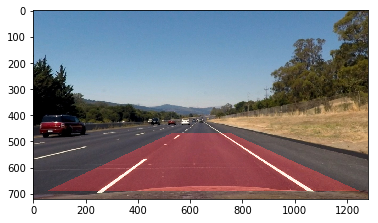

In [20]:
raw = cv2.cvtColor(cv2.imread(straightline_images[1]),cv2.COLOR_BGR2RGB)
undist = undistortion(raw)
msk = np.zeros_like(undist)
cv2.fillPoly(msk,np.int_([src]),color = [255, 0, 0])
to_plot = cv2.addWeighted(undist,1,msk,0.3,0)
plt.imshow(to_plot)
plt.savefig('source_points.png')

### Define the destination points (Here same size as the original)


In [21]:
offset, img_size = 0, (raw.shape[1], raw.shape[0])
dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
                                     [img_size[0]-offset, img_size[1]-offset], 
                                     [offset, img_size[1]-offset]])

In [22]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst,src)
# Save the perspective transform matrices for later use 
name_perspective = 'perspective.p' 
dist_pickle = {}
dist_pickle["M"] = M
dist_pickle["Minv"] = Minv
pickle.dump( dist_pickle, open( name_perspective, "wb" ) )

### Visual checking of the transform (Making sure that lines are indeed parallel after transform and see how the binary pipline behaves)

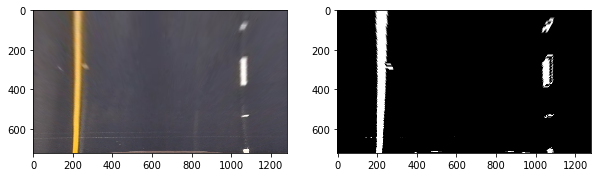

In [23]:
for fname in straightline_images[:1]:
    raw = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
    undist = undistortion(raw)
    warped = cv2.warpPerspective(undist, M, (img_size))
    binary, _ = binary_pipeline(undist, thresholds)
    binary_warped = cv2.warpPerspective(binary, M, (img_size))
    fig, ax = plt.subplots(1,2,figsize=(10,5))
    ax[0].imshow(warped)
    ax[1].imshow(binary_warped, cmap = 'gray')
    plt.show()
    name = fname.replace(path_test_images,path_out).replace('.jpg','bird.jpg')
    fig.savefig(name)

# 4- Line finding pipeline
The goal of this part is to define an intermediary pipeline that takes a binary image where the lane lines stand out clearly and performs the following tasks:
- decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line. This can be done either using a sliding window method or using information about the left and right lines fit on the previous frame
- use that pixels to fit parabola that best describe the left and right lines
- compute useful information about the road, such as its widths, curvature...


In [24]:
def find_lane(binary_warped, prior = None):
    '''
    The function takes as input a binary image from a bird's eye perspective and a parameter prior (either None or dictionnary
    with keys left_fit and right_fit which respectively contain the coefficients of the polynome fit on the lines of the 
    previous frame). It has two modes depending on the nature of prior
    - prior = None: Seach from scratch using a histogram and sliding window
    - prior = dictionnary: Search the line using the prior line to narrow down the search area
    Outputs : 
    - results dictionnary with keys
        - fit: contains relevant information about the fit of the left and right lines (coefficients)
        - road: contains revelant information about the road (its curvature, its width, the position of the car)
    - visualization 3 chanels image
    '''
    img_shape = binary_warped.shape
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 20/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension
    # Set the width of the windows +/- margin
    margin = 100
    
    def fit_polynomial(img_shape, lefty, leftx, rightx, righty):
        # Fit a second order polynomial to each using `np.polyfit`
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
        ### Calc both polynomials using ploty, left_fit and right_fit ###
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        fit_line = {}
        fit_line['left_fit'], fit_line['right_fit'] = left_fit, right_fit
        fit_line['left_fitx'], fit_line['right_fitx'] = left_fitx, right_fitx
        fit_line['ploty'] = ploty
        return fit_line
    
    def curvature_in_meters(ploty, fit):
        # Coefficients in curvature formula
        A = xm_per_pix*fit[0]/(ym_per_pix**2)
        B = xm_per_pix*fit[1]/ym_per_pix
        # y to evaluate curvature
        y_eval = np.max(ploty)
        # Calculation of R_curve (radius of curvature)
        curvature = ((1 + (2*A*y_eval + B)**2)**1.5) / np.absolute(2*A)
        return curvature
    
    if prior is None:
        # Hyperparameters
        # Choose the number of sliding windows
        nwindows = 8
        # Set minimum number of pixels found to recenter window
        minpix = 50
        # Process
        # - Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        # (VISUALIZATION) Create an output image to draw on and visualize the result
        #out_img = np.dstack((binary_warped, binary_warped, binary_warped))
        out_img = np.zeros(shape=(*img_shape,3))
        # - Find the peak of the left and right halves of the histogram
        #   These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        # - Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//nwindows)
        # - Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # - Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base
        # - Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []
        # - Sliding window method
        for window in range(nwindows):
            # -- Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin

            # (VISUALIZATION) Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                          (win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),
                          (win_xright_high,win_y_high),(0,255,0), 2) 
        
            # -- Identify the nonzero pixels in x and y within the window #
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                              (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
            # -- Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
        
            # -- If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # - Concatenate the arrays of indices (previously was a list of lists of pixels)
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
        
        # (VISUALIZATION)
        # -- Extract left and right line pixel positions
        leftx, lefty = nonzerox[left_lane_inds], nonzeroy[left_lane_inds]
        rightx, righty = nonzerox[right_lane_inds], nonzeroy[right_lane_inds]
        # -- Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]
        visualization = out_img.astype(np.uint8)
        
        # - Line estimation by polyfit 
        fit_line = fit_polynomial(img_shape, lefty, leftx, rightx, righty)
        
    else :
        # Process
        # - Grab activated pixels
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # - Get the prior polynome coefficients
        left_fit, right_fit = prior['left_fit'], prior['right_fit']
        # - We set the area of search based on activated x-values 
        #   within the +/- margin of our polynomial function 
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                        left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                        right_fit[1]*nonzeroy + right_fit[2] + margin)))

        # - Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        # - Fit new polynomials
        fit_line = fit_polynomial(img_shape, lefty, leftx, rightx, righty)
        left_fitx, right_fitx, ploty = fit_line['left_fitx'], fit_line['right_fitx'], fit_line['ploty']
        # (VISUALIZATION) 
        # -- Create an image to draw on and an image to show the selection window
        out_img = np.zeros(shape=(*img_shape,3))
        window_img = np.zeros_like(out_img)
        # -- Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        # -- Generate a polygon to illustrate the search window area
        #   And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        visualization = cv2.addWeighted(out_img, 1, window_img, 0.3, 0).astype(np.uint8)

        
    # Output formating
    results = {}
    # - Fit line
    results['fit'] = fit_line
    # - Road information estimation
    road = {}
    road['left_curvature'] = curvature_in_meters(fit_line['ploty'], fit_line['left_fit'])
    road['right_curvature'] = curvature_in_meters(fit_line['ploty'], fit_line['right_fit'])
    road['offset'] = (float(img_shape[1])/2-(fit_line['right_fitx'][-1]-fit_line['left_fitx'][-1])/2)*xm_per_pix
    road['distance'] = (fit_line['right_fitx'][-1]-fit_line['left_fitx'][-1])*xm_per_pix
    results['road'] = road

    return results, visualization

### Testing the find_lane function

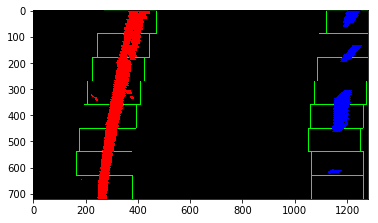

In [25]:
# Without prior
image = cv2.cvtColor(cv2.imread(test_images[1]),cv2.COLOR_BGR2RGB)
undist = undistortion(image)
binary, _ = binary_pipeline(undist, thresholds)
binary_warped = cv2.warpPerspective(binary, M, img_size)
results, visualization = find_lane(binary_warped, prior = None)
plt.imshow(visualization)
plt.savefig(os.path.join(path_out,'find_lane_without_prior.jpg'))

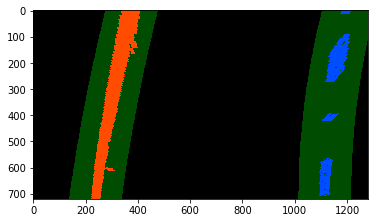

In [26]:
# With prior
prior = {}
prior['left_fit'], prior['right_fit'] = results['fit']['left_fit'], results['fit']['right_fit']
image = cv2.cvtColor(cv2.imread(test_images[3]),cv2.COLOR_BGR2RGB)
undist = undistortion(image)
binary, _ = binary_pipeline(undist, thresholds)
binary_warped = cv2.warpPerspective(binary, M, img_size)
results, visualization = find_lane(binary_warped, prior = prior)
plt.imshow(visualization)
plt.savefig(os.path.join(path_out,'find_lane_with_prior.jpg'))

# Final pipeline

### Useful Line class to keep information throughout frames

In [28]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n = 15):
        # was the line detected in the last iteration?
        self.detected = False  
        #polynomial coefficients over the last n iterations (NOT AVERAGED)
        self.previous_fits = deque(maxlen=n)
        #polynomial coefficients for the most recent fit
        self.current_fit = None  
        # Number of frames where the algorithms failed
        self.fail = 0
        # Previous estimated curvature
        self.previous_curvatures = deque(maxlen=n)
        # Previous estimated offset
        self.previous_offsets = deque(maxlen=n)

### Process image pipeline

In [29]:
def process_image(image):
    '''
    This functions takes as input a RGB image, performs a line detection and provides an annotated image when the detection is
    successful. 
    It begins first with a process of the current frame (step A). Followed by a sanity check (step B) that decides
    if the detected lines make sense. Finally, an annotated image is computed
    '''
    # Hyperparameters
    fail_max = 15
    ndeque = 15
    # A- Estimation on the current frame
    # - Undistorsion 
    undist = undistortion(image)
    # - Binary image
    binary, _ = binary_pipeline(undist, thresholds)
    # - Bird perspective
    binary_warped = cv2.warpPerspective(binary, M, img_size)
    # - Fit a line
    if rightline.detected & leftline.detected : # If lines were detected on the previous frame
        # Then use the previous parabola to narrow down the search of the pixels
        prior = {}
        prior['left_fit'], prior['right_fit'] = leftline.current_fit, rightline.current_fit # 
    else : # If not
        if len(leftline.previous_fits)==0 & len(rightline.previous_fits)==0: # If no detection was successful before
            prior  = None # Perform a line search from scratch using the sliding window method
        else: # If detections were successful before, use the average fit as prior
            averaged_left_fit = np.mean(np.array(leftline.previous_fits), axis = 0)
            averaged_right_fit = np.mean(np.array(rightline.previous_fits), axis = 0)
            prior = {}
            prior['left_fit'], prior['right_fit'] = averaged_left_fit, averaged_right_fit
            
    results, visualization =  find_lane(binary_warped, prior = prior)
    
    left_fit = results['fit']['left_fit']
    right_fit = results['fit']['right_fit']
    ploty = results['fit']['ploty']
    left_fitx = results['fit']['left_fitx']
    right_fitx = results['fit']['right_fitx']
    left_curvature = results['road']['left_curvature']
    right_curvature = results['road']['right_curvature']
    distance = results['road']['distance']
    offset = results['road']['offset']
    #print(results['road'])
    
    # B- SANITY CHECK 
    # - Right and left lanes have similar curvature
    threshold_curvature = 6000
    delta_curvature = abs(left_curvature-right_curvature)
    ok_curvature = delta_curvature < threshold_curvature
    # - Good distance between the two lines
    threshold_distance = 2
    delta_distance = abs(distance-3.7)
    ok_distance = delta_distance < threshold_distance
    # - Parallel 
    ok_parallel = True
    # - Final check 
    check = ok_curvature & ok_distance & ok_parallel
    
    if check:
        # Left line
        leftline.detected = True
        leftline.previous_fits.append(left_fit)
        leftline.current_fit = left_fit
        leftline.previous_curvatures.append(left_curvature)
        leftline.previous_offsets.append(offset)
        
        # Right line
        rightline.detected = True
        rightline.previous_fits.append(right_fit)
        rightline.current_fit = right_fit     
        rightline.previous_curvatures.append(right_curvature)
        rightline.previous_offsets.append(offset)
    else: 
        leftline.detected = False
        rightline.detected = False
        leftline.fail +=1
        rightline.fail +=1
        
        if leftline.fail > fail_max:
            leftline.previous_fits = deque(maxlen=ndeque)
            rightline.previous_fits = deque(maxlen=ndeque)
            leftline.previous_curvatures = deque(maxlen=ndeque)
            rightline.previous_curvatures = deque(maxlen=ndeque)
            leftline.previous_offsets = deque(maxlen=ndeque)
            rightline.previous_offsets = deque(maxlen=ndeque)
            leftline.fail = 0
            rightline.fail = 0
        
    # (VISUALIZATION) 
    if len(leftline.previous_fits)>0:
        # -- Average the previous fit
        averaged_left_fit = np.mean(np.array(leftline.previous_fits), axis = 0)
        averaged_right_fit = np.mean(np.array(rightline.previous_fits), axis = 0)
        
        left_fitx = averaged_left_fit[0]*ploty**2 + averaged_left_fit[1]*ploty + averaged_left_fit[2]
        right_fitx = averaged_right_fit[0]*ploty**2 + averaged_right_fit[1]*ploty + averaged_right_fit[2]
        # -- Create an image to draw the lines on
        warp_zero = np.zeros_like(binary_warped ).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
        # -- Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        # -- Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts[0]]), (0,255, 0))
        # -- Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
        # -- Combine the result with the original image
        to_plot = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        # Annotation
        curvature = (np.mean(leftline.previous_curvatures) + np.mean(rightline.previous_curvatures))/2
        text_str = 'Curvature: {:.1f} m'.format(curvature)
        to_plot = cv2.putText(to_plot, text_str, (30,40), 0, 1, (255,0,0), 2, cv2.LINE_AA)
        offset = np.mean(leftline.previous_offsets)
        text_str = 'Offset : {:.1f} m'.format(offset)
        to_plot = cv2.putText(to_plot, text_str, (30,70), 0, 1, (255,0,0), 2, cv2.LINE_AA)
    else:
        # Returns the original image after undistortion
        to_plot = undist
        
    return to_plot

### Pipeline testing on images

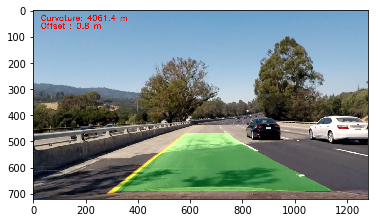

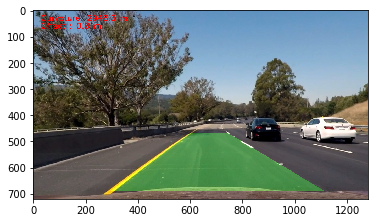

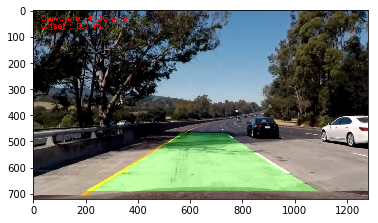

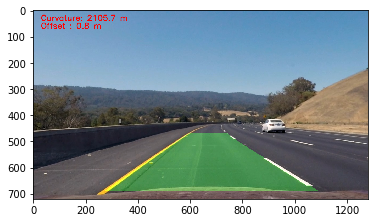

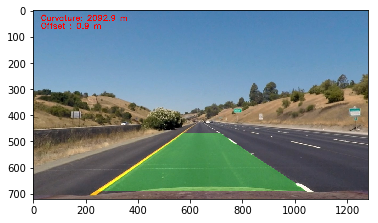

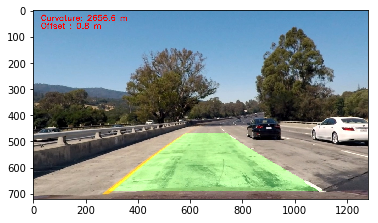

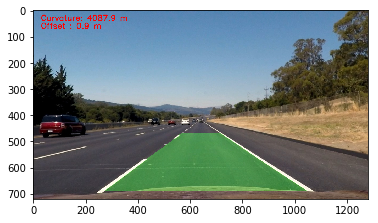

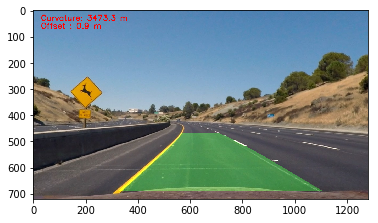

In [30]:
for fname in test_images:
    leftline, rightline = Line(), Line()
    image = cv2.cvtColor(cv2.imread(fname),cv2.COLOR_BGR2RGB)
    to_plot= process_image(image)
    plt.imshow(to_plot)
    plt.show()
    name = fname.replace(path_test_images,path_out).replace('.jpg','final.jpg')
    fig.savefig(name)


In [31]:
! ls output_images/

calibration10result.jpg  calibration4result.jpg       test1binary.jpg
calibration11result.jpg  calibration5result.jpg       test1final.jpg
calibration12result.jpg  calibration6result.jpg       test2binary.jpg
calibration13result.jpg  calibration7result.jpg       test2final.jpg
calibration14result.jpg  calibration8result.jpg       test3binary.jpg
calibration15result.jpg  calibration9result.jpg       test3final.jpg
calibration16result.jpg  find_lane_without_prior.jpg  test4binary.jpg
calibration17result.jpg  find_lane_with_prior.jpg     test4final.jpg
calibration18result.jpg  save_output_here.txt	      test4undistortion.jpg
calibration19result.jpg  straight_lines1binary.jpg    test5binary.jpg
calibration1result.jpg	 straight_lines1bird.jpg      test5final.jpg
calibration20result.jpg  straight_lines1final.jpg     test6binary.jpg
calibration2result.jpg	 straight_lines2binary.jpg    test6final.jpg
calibration3result.jpg	 straight_lines2final.jpg


# Final test of the pipeline on videos

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
videos = ['project_video.mp4']

In [34]:
for video in videos:
    output = 'output_videos/' + video
    leftline, rightline = Line(), Line()
    clip1 = VideoFileClip(video)
    white_clip = clip1.fl_image(process_image) 
    %time white_clip.write_videofile(output, audio=False)
    HTML("""<video width="960" height="540" controls>
    <source src="{0}">
    </video>
    """.format(output))

[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████▉| 1260/1261 [08:09<00:00,  2.58it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

CPU times: user 5min 54s, sys: 4.22 s, total: 5min 58s
Wall time: 8min 12s
